# Project

In [ ]:
%matplotlib inline
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import *
import tdmclient.notebook
await tdmclient.notebook.start()


In [ ]:
# parametres
stop = 0
MIN_DIST = 25
MIN_OBST_DIST = 1000
ANGLE_TOLERANCE = 0.40
SPEED_AVG = 200
ROBOT_SPEED_TO_MM = 120/500
IR_SCALE_DOWN = 0.01

LEFT_IR_WEIGHT = [2,4,6,-4,-2,0,0]
RIGHT_IR_WEIGHT = [-2,-4,-6,4,2,0,0]

period = 0.25
nb_samples = int(3/period)
prox_int = np.zeros((1,nb_samples))
state = 'tracking'
timer = 0


@tdmclient.notebook.sync_var
def prox():
    global prox_horizontal
    # get the prox values   
    prox_vals = np.array(prox_horizontal) * IR_SCALE_DOWN
    return prox_vals

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

def controller(angle):
    kp_rot = 100
    kp_lin = 3
    obst = False

    prox_vals = prox()
    if sum(prox_vals) > 0:
        obst = True
    if obst == True:
        print(sum(prox_vals * LEFT_IR_WEIGHT), sum(prox_vals * RIGHT_IR_WEIGHT))
        speed_l = sum(prox_vals * LEFT_IR_WEIGHT)  + 25
        speed_r = sum(prox_vals * RIGHT_IR_WEIGHT) + 25
    else:
        if abs(angle) > ANGLE_TOLERANCE:
            speed_l = 80 - kp_rot*(angle)
            speed_r = 80 + kp_rot*(angle)
        else:
            speed_l = SPEED_AVG
            speed_r = SPEED_AVG
    return int(speed_l), int(speed_r)

def pathing (video_capture, path, x0, y0, theta0):
    global period
    cam_hist = []
    kal_hist = []
    pred_hist = []

    teta = np.zeros(np.shape(path)[0])
    speed_l = speed_r = 0
    goalx = path[1][0]
    goaly = path[1][1]
    theta_measure = 0
    i = 1
    curr_time = 0
    kx = kteta = ky = angle = 0
    robot_detected = False
    camera_available = False
    dist = distance (goalx, goaly, kx, ky)
    
    # kalman variables 
    P = 1000*np.eye(3)
    x = x_predicted = np.array([[x0],[y0],[theta0]])
    z = np.array([[0],[0],[0]])
    u = np.array([[0],[0]])
    previous_time = 0
    
    previous_time, x, P, x_predicted = kalman_filter(True, x, u, z, P , previous_time)

    while True:       
        #   step 1: get the image, detect the robot, and get the position
        current_time = time.time()
        camera_available, frame = video_capture.read()
        position_measure = []
        if camera_available == True:
            position_measure, position_contour, proccessed_framed = computer_vision(frame, 'robot', False)
            # cv has detected the robot, we can use the position
            if len(position_measure) == 1:
                robot_detected = True
                position_measure = position_measure[0]

                if position_measure is not None:                    
                    _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                    theta_measure = round(-theta_measure, 4)
                    position_measure = invert_coordinates(position_measure)
                    position_measure = pixel_to_metric(position_measure)
                    [kx, ky, kteta] = [position_measure[0], position_measure[1], theta_measure]
                    measurement = np.array([kx, ky, kteta])
                else:
                    robot_detected = False
            else:
            # robot not detected, we use kalman
                robot_detected = False
        vals = prox()
        
        print(vals)
        if camera_available == False or robot_detected == False:
            measurement = np.array([0,0,0])         # CHECK WHY 0,0,0            
        
        z = np.array([[measurement[0]], [measurement[1]], [measurement[2]]])
        previous_time, x, P, x_predicted = kalman_filter(robot_detected, x, u, z, P , previous_time)
        [pred_x, pred_y, pred_teta] = x
        
        
        dist = distance (goalx, goaly, pred_x, pred_y)
        #print(i, robot_detected, dist)
        teta[i] = math.atan2((goaly - pred_y), (goalx - pred_x)) #change angle according to kalman
    

        if (dist < MIN_DIST):
            if i < np.shape(path)[0] - 1 :
                i = i + 1
                goalx = path[i][0]
                goaly = path[i][1]
            else:
                motors(stop, stop)
                break
        else :
            angle =  wrap_angle((teta[i] - pred_teta) % (2*np.pi))

            speed_l, speed_r = controller(angle)
   
        u = np.array([[speed_l],[speed_r]]) * ROBOT_SPEED_TO_MM
       # print(speed_l, speed_r)
        motors(speed_l, speed_r)

        cam_hist.append([kx, ky, kteta])
        kal_hist.append([pred_x, pred_y, pred_teta])
        pred_hist.append([goalx, goaly, teta[i]])
        end_time = time.time()
        period = end_time - current_time      

    motors(stop, stop)
    return cam_hist, kal_hist, pred_hist
    

# Main 

1
2
3
start = [ 78.15789474 148.78947368] goal = [463.73684211 337.52631579] angle = -2.516107613350564


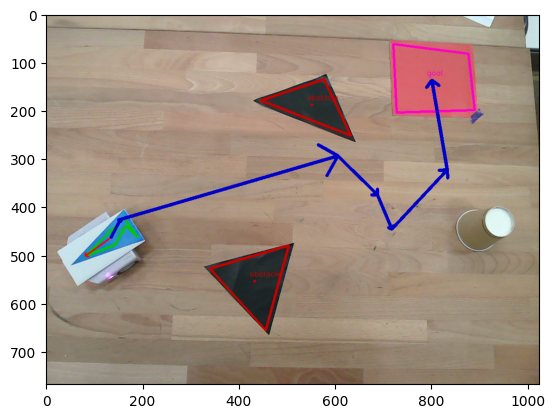

In [20]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)

cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-7)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)

if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
        
    metric_path = np.zeros(np.shape(path))

    # invert y axis
    for i in range(len(path)):
        path[i] = invert_coordinates(path[i])
    metric_start = invert_coordinates(start)
    metric_goal = invert_coordinates(goal)

    # change to metric  

    for i in range(len(path)):
        metric_path[i] = pixel_to_metric(path[i])
    metric_start = pixel_to_metric(metric_start)
    metric_goal = pixel_to_metric(metric_goal)
    
    
    print('start =', metric_start, 'goal =', metric_goal, 'angle =', -robot[2])

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [21]:
cam, kal, pred = pathing(video_capture, metric_path, metric_start[0], metric_start[1], -robot[2])
print("finished")
motors(stop, stop)


[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0

In [ ]:
motors(stop, stop)
ret, frame = video_capture.read()
print(ret)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cv2.imwrite('frame.jpeg', frame)


In [22]:
cam_copy = np.array(cam)
kal_copy = np.array(kal)
pred_copy = np.array(pred)
obst_copy  = np.array(obst)


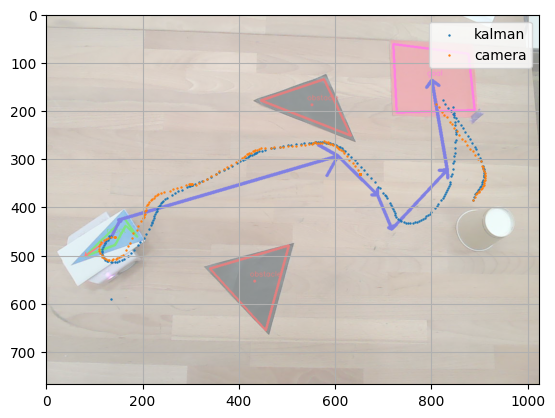

In [26]:
#plot 
pixel_cam = np.zeros(np.shape(cam_copy))
pixel_kal = np.zeros(np.shape(kal_copy))
pixel_pred = np.zeros(np.shape(pred_copy))
# transform to pixel
for i in range(len(cam)):
    pixel_cam[i] = metric_to_pixel(cam_copy[i])
    pixel_kal[i] = metric_to_pixel(kal_copy[i])
    pixel_pred[i] = metric_to_pixel(pred_copy[i])

implot = plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), origin='upper', alpha=0.5)
plt.scatter(pixel_kal[:,0], -pixel_kal[:,1] + CAMERA_HEIGHT, label='kalman', s = 0.5)
plt.scatter(pixel_cam[:,0], -pixel_cam[:,1]+ CAMERA_HEIGHT, label='camera', s=0.5)
#plt.scatter(pixel_pred[:,0], -pixel_pred[:,1]+ CAMERA_HEIGHT, label='predicted', s=0.5)


plt.legend()
plt.grid()

plt.show()
